In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
import pandas as pd

In [2]:
matriz = np.loadtxt('matriz-rutas-granada.txt')

matriz = matriz + matriz.T

In [3]:
Q = matriz[:6, :6]
Q = Q/np.max(Q)
#Q = np.array(
#    [
#        [-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
#        [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
#        [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
#        [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
#        [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0],
#    ]
#)

In [4]:
def evaluate_mapping(new_coords, Q):
    """Cost function to minimize. Ideally, the pairwise distances are conserved."""
    new_coords = np.reshape(new_coords, (len(Q), 2))
    # computing the matrix of the distances between all coordinate pairs
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
    )
    return np.linalg.norm(new_Q - Q)

In [5]:
def biggest_difference(new_Q, Q):
    """Calcula el mayor error relativo entre los elementos de las matrices new_Q y Q,
    solo considerando los valores donde Q no sea cero."""
    
    # Crear una máscara para los valores donde Q no es cero
    mask = Q != 0  
    
    # Calcular error relativo solo en los elementos donde Q ≠ 0
    relative_errors = 100*np.abs((new_Q[mask] - Q[mask]) / Q[mask])
    
    # Devolver el máximo error relativo encontrado
    return np.max(relative_errors)

In [6]:
def compute_element_U(coords):
    return (DigitalAnalogDevice.interaction_coeff / (pdist(coords)[0]) ** 6)

In [7]:
costs = []
np.random.seed(0)
#x0 = np.random.random(len(Q) * 2)
min_Q = np.min(Q[Q>0])
max_Q = np.max(Q)
x0 = np.random.uniform(min_Q, max_Q, size=len(Q) * 2)

res = minimize(
    evaluate_mapping,  # Función a minimizar
    x0,  # Punto inicial
    args=(Q,),  # Parámetro que hay que pasar a la función a minimizar
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 2000000, "maxfev": None},
)
coords = np.reshape(res.x, (len(Q), 2))

In [8]:
coords

array([[ 12.83502755,  12.01191227],
       [ -2.59505015,  -9.58492782],
       [-14.24863942,  -1.77176003],
       [  1.10639462,  23.71078219],
       [  8.47491016,  -2.31860688],
       [ -2.34056646,   6.23983654]])

In [9]:
# Calcular la nueva matriz de distancias con la configuración óptima
new_Q = squareform(DigitalAnalogDevice.interaction_coeff / pdist(coords) ** 6)


In [10]:
new_Q

array([[0.        , 0.01550062, 0.00688146, 0.26226714, 0.47983515,
        0.29586876],
       [0.01550062, 0.        , 0.71054937, 0.00383424, 1.00541049,
        0.34486696],
       [0.00688146, 0.71054937, 0.        , 0.00781593, 0.03930073,
        0.62013605],
       [0.26226714, 0.00383424, 0.00781593, 0.        , 0.01382903,
        0.16996506],
       [0.47983515, 1.00541049, 0.03930073, 0.01382903, 0.        ,
        0.78746863],
       [0.29586876, 0.34486696, 0.62013605, 0.16996506, 0.78746863,
        0.        ]])

In [11]:
Q

array([[0.        , 0.54223093, 0.27136423, 0.2533182 , 0.46775606,
        0.29473804],
       [0.54223093, 0.        , 0.70672347, 0.22003514, 1.        ,
        0.34754938],
       [0.27136423, 0.70672347, 0.        , 0.55099481, 0.27184104,
        0.60986986],
       [0.2533182 , 0.22003514, 0.55099481, 0.        , 0.72257205,
        0.12774228],
       [0.46775606, 1.        , 0.27184104, 0.72257205, 0.        ,
        0.78144192],
       [0.29473804, 0.34754938, 0.60986986, 0.12774228, 0.78144192,
        0.        ]])

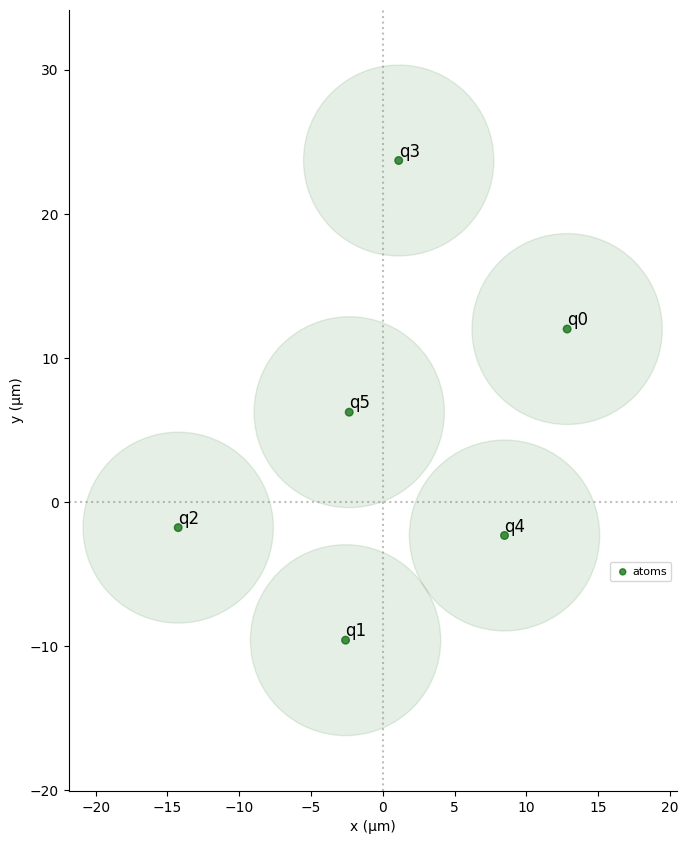

In [12]:
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
reg = Register(qubits)
reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

#### Embedding heurístico

In [13]:
def heuristical_embedding(V, P, Q):
    '''
    Register Embedding Algorithm (arxiv.org/pdf/2402.05748)

    V : set of atoms [0, ..., N-1]

    P : set of positions (grid of positions)
    
    Q : QUBO matrix
    '''
    Pa = [] # list of already assigned positions

    u = V[0]
    center = (0.0, 0.0)
    Pa.append([u, center])

    # Update the remaining atoms and positions
    V.remove(u)
    P.remove(center)

    # Initialize the interactions matrix U
    U = np.zeros((len(Q), len(Q)))

    while V:
        u = V[0]
        min_sum = float("inf")
        for p in P:
            sum = 0
            for atom_position in Pa:
                # For every already places atom, we unpack the value of the atom and its position
                v = atom_position[0] 
                pv = atom_position[1]

                sum += sum + np.abs(Q[u,v]-compute_element_U(np.vstack([p,pv])))
                
            # If we find the best position available so far
            if sum<min_sum:
                # Update best position and the actual min_sum
                min_sum = sum
                best_position = p

            # We keep looking for better positions until we have examined all of them

        # Update the remaining atoms and position sets and the placed atoms-positions list
        Pa.append([u, best_position])
        P.remove(best_position)
        V.remove(u)

        # Prepare the coordinates in array form
        coords = np.array([item[1] for item in Pa])

    return coords

In [14]:
Q = matriz[:5, :5]

In [15]:
atoms_list = [ _ for _ in range(len(Q))]

In [16]:
atoms_list

[0, 1, 2, 3, 4]

In [17]:
import itertools

def generate_grid(x_max, y_max, g):
    """Genera un grid de puntos en el rango [0, x_max] x [0, y_max] con espaciado g.
    
    Args:
        x_max (float): Máximo valor en el eje X.
        y_max (float): Máximo valor en el eje Y.
        g (float): Granularidad (espaciado entre puntos).

    Returns:
        list: Lista de posiciones disponibles en formato [(x1, y1), (x2, y2), ...].
    """
    x_vals = np.round(np.arange(-x_max-g, x_max+g, g), 2)  # Valores en X
    y_vals = np.round(np.arange(-y_max-g, y_max+g, g), 2)  # Valores en Y

    P = list(itertools.product(x_vals, y_vals))  # Producto cartesiano para crear el grid
    return P

available_positions = generate_grid(20, 20, 0.01)

In [19]:
coords = heuristical_embedding(atoms_list.copy(), available_positions.copy(), Q)

In [20]:
new_Q = squareform(DigitalAnalogDevice.interaction_coeff / pdist(coords) ** 6)


In [21]:
new_Q

array([[ 0.        , 10.46240991,  5.24134597,  4.87746691,  9.03397238],
       [10.46240991,  0.        , 13.65048868,  0.42779248, 19.3282912 ],
       [ 5.24134597, 13.65048868,  0.        , 10.60831036,  0.40794924],
       [ 4.87746691,  0.42779248, 10.60831036,  0.        ,  0.11429153],
       [ 9.03397238, 19.3282912 ,  0.40794924,  0.11429153,  0.        ]])

In [23]:
Q

array([[ 0.    , 10.4624,  5.236 ,  4.8878,  9.0254],
       [10.4624,  0.    , 13.6363,  4.2456, 19.2951],
       [ 5.236 , 13.6363,  0.    , 10.6315,  5.2452],
       [ 4.8878,  4.2456, 10.6315,  0.    , 13.9421],
       [ 9.0254, 19.2951,  5.2452, 13.9421,  0.    ]])

#### Exploración

In [ ]:
methods = [
    "Nelder-Mead",  # Algoritmo simplex (no requiere derivadas)
    "Powell",       # Algoritmo de búsqueda direccional (sin derivadas)
    "L-BFGS-B",     # Variante limitada de BFGS (acepta restricciones de caja)
    "TNC",          # Algoritmo de Newton truncado (adecuado para problemas grandes)
    "COBYLA",       # Optimización secuencial por aproximaciones cuadráticas
    "SLSQP"         # Programación cuadrática secuencial
]



/var/folders/k8/_n773mp15jj5bc5xfk5zrrkm0000gn/T/ipykernel_1365/2030765085.py:10: OptimizeWarning: Unknown solver options: maxfev
  res = minimize(
/var/folders/k8/_n773mp15jj5bc5xfk5zrrkm0000gn/T/ipykernel_1365/2030765085.py:10: OptimizeWarning: Unknown solver options: maxiter, maxfev
  res = minimize(
/Users/victor/Desktop/pulser/p/lib/python3.13/site-packages/scipy/optimize/_minimize.py:744: OptimizeWarning: Unknown solver options: maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


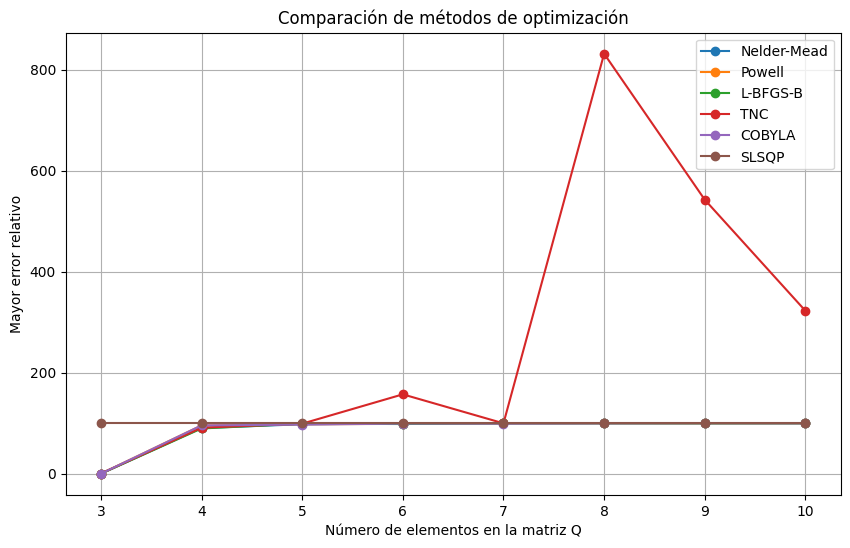

In [ ]:
results = {method_ : [] for method_ in methods}
Q = matriz
for method_ in methods:
    
    for n_elements in range (3,11):
        
        Q_ = Q[:n_elements, :n_elements]
        np.random.seed(0)
        x0 = np.random.random(len(Q_) * 2)
        res = minimize(
            evaluate_mapping, #función a minimizar
            x0, #punto inicial
            args=(Q_,), #parámetro que hay que pasar a la función a minimizar
            method=method_,
            tol=1e-6,
            options={"maxiter": 2000000, "maxfev": None},
        )
        coords = np.reshape(res.x, (len(Q_), 2))
        new_Q = squareform(DigitalAnalogDevice.interaction_coeff / pdist(coords) ** 6)

        # Calcular y almacenar la mayor diferencia relativa
        max_error = biggest_difference(new_Q, Q_)
        results[method_].append(max_error)

# Graficar los resultados
plt.figure(figsize=(10, 6))
for method_, errors in results.items():
    plt.plot(range(3, 11), errors, marker="o", label=method_)

plt.xlabel("Número de elementos en la matriz Q")
plt.ylabel("Mayor error relativo")
plt.title("Comparación de métodos de optimización")
plt.legend()
plt.grid(True)
plt.show()


        